<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [25]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
import sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import auc, roc_curve, roc_auc_score 

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Global parameters </h6>

In [26]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = Perceptron(random_state=random_state, n_jobs=-1, class_weight="balanced")
model_name = "Perceptron"

learning_curve_flag = False
v_or_t_flag = "TST"
cmap = plt.cm.Greys
color = "grey"

<h6> Datasets loading </h6>

In [27]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6>Continous, categorical/ordinal column retrieval</h6>

In [28]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [29]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [30]:
numeric_columns_vt = list(set(numeric_columns).intersection(set(X_train_vt.columns)))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [31]:
categoric_columns_vt = list(set(categoric_columns).intersection(set(X_train_vt.columns)))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


In [32]:
# UPDATE NUMERIC COLUMNS VERSION 
ordinal_columns = ['track_date_created_year', 'track_date_created_season']
numeric_columns = ordinal_columns + numeric_columns
numeric_columns_vt = ordinal_columns + numeric_columns_vt

<h6>Define current (filtered) train and test</h6>

In [33]:
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()

X_tr_vt = X_train_vt.copy()
X_ts_vt = X_test_vt.copy()

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h1>Perceptron (baseline classifier)</h1>

In [34]:
def model_baseline_classification(X_tr, y_tr, X_ts, y_ts):
    fitted_model = model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_ts)
    
    print(confusion_matrix(y_ts, y_pred))
    print(classification_report(y_ts, y_pred))
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.feature_importances_),reverse=True)
        # print(features_importance)
    except:
        pass
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.coef_),reverse=True)
        # print(features_importance)
    except:
        pass

<h6>All features (categorica, ordinal and continous)</h6>

In [35]:
model_baseline_classification(X_train, 
                              y_train, 
                              X_test, 
                              y_test)

[[9692  102]
 [1051   29]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9794
           1       0.22      0.03      0.05      1080

    accuracy                           0.89     10874
   macro avg       0.56      0.51      0.50     10874
weighted avg       0.83      0.89      0.85     10874



<h6>Only continous variables</h6>

In [36]:
model_baseline_classification(X_train[numeric_columns], 
                              y_train, 
                              X_test[numeric_columns], 
                              y_test)

[[9661  133]
 [1037   43]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9794
           1       0.24      0.04      0.07      1080

    accuracy                           0.89     10874
   macro avg       0.57      0.51      0.51     10874
weighted avg       0.84      0.89      0.86     10874



<h6>Only categorical or ordinal variables</h6>

In [37]:
model_baseline_classification(X_train[categoric_columns], 
                              y_train, 
                              X_test[categoric_columns], 
                              y_test)

[[8973  821]
 [ 708  372]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      9794
           1       0.31      0.34      0.33      1080

    accuracy                           0.86     10874
   macro avg       0.62      0.63      0.62     10874
weighted avg       0.87      0.86      0.86     10874



<h2> Tuned Perceptron </h2>

Like logistic regression, it can quickly learn a linear separation in feature space for two-class classification tasks, although unlike logistic regression, it learns using the **stochastic gradient descent optimization** algorithm and does **not predict calibrated probabilities**.


A Perceptron is a **single neuron model** that was a precursor to larger neural networks. It takes a row of data as input and predicts a class label. This is achieved by calculating the weighted sum of the inputs and a bias (set to 1). The **weighted sum of the input** of the model is called the **activation**:
\begin{equation}
Activation = Weights * Inputs + Bias
\end{equation}

If the activation is above 0.0, the model will output 1.0; otherwise, it will output 0.0:
- Predict 1: If Activation > 0.0
- Predict 0: If Activation <= 0.0

The predictive capability of neural networks comes from the **hierarchical/multilayered structure** of
the networks. **The data structure can learn to represent features at different scales or
resolutions and combine them into higher-order features**. 

<h6>Neurons</h6>
The building block for neural networks are **artificial neurons**. These are simple computational
units that have **weighted input signals** and produce an **output signal** using an **activation function**.

<h6>Neuron Weights</h6>
The weights on the inputs are very much **like the coefficients used in a regression equation**. Like linear regression, each neuron also has a **bias** which can be thought of as an input that always has the value 1.0 and it too must be weighted. [For example, a neuron may have two inputs in which case it requires three weights.
One for each input and one for the bias]

N.B. Weights are often initialized to small random values, such as values in the range 0 to 0.3

<h6>>Activation</h6>
The weighted inputs are summed and passed through an activation function. An activation function is a simple **mapping of summed weighted input to the output of the neuron**. It is called an activation function because **it governs the threshold at which the neuron is activated and the strength of the output signal** [for example
0.5, then the neuron would output a value of 1.0, otherwise it would output a 0.0].

Traditionally **nonlinear activation functions are used**. This allows the network to combine
the inputs in more complex ways and in turn provide a richer capability in the functions they
can model:
- logistic function / sigmoid function were used that output a value between 0 and 1 with an s-shaped distribution;
- hyperbolic tangent function / Tanh that outputs the same distribution over the range -1 to +1'
- rectifier activation function has been shown to provide better results.

<h6>Networks of Neurons</h6>
Neurons are arranged into **networks of neurons**. A row of neurons is called a layer and one
network can have multiple **layers**.

<h6>Input/visible layers</h6>
The bottom layer that takes input from your dataset is called the visible layer. These are not neurons as described above, but simply pass the input value though to the next layer.

N.B. Often a neural network is drawn with a visible layer with one neuron per input value or column in your dataset.

<h6>Hidden Layers</h6>
Layers after the input layer are called hidden layers because they are not directly exposed to
the input. The simplest network structure is to have a single neuron in the hidden layer that
directly outputs the value (Percepton). Deep learning can refer to having many hidden layers in
your neural network.

<h6>Output layer</h6>
The final hidden layer is called the output layer and it is responsible for **outputting a value
or vector of values** that correspond to the format required for the problem. The choice of
activation function in the output layer is strongly constrained by the type of problem that you
are modeling:
- A regression problem may have a single output neuron and the neuron may have no
activation function;
- A binary classification problem may have a single output neuron and use a sigmoid
activation function to output a value between 0 and 1 to represent the probability of
predicting a value for the primary class. This can be turned into a crisp class value by
using a threshold of 0.5 and snap values less than the threshold to 0 otherwise to 1.

<h6>Stochastic Gradient Descent</h6>
The classical training algorithm for neural networks is called stochastic
gradient descent. This is where **one row of data is exposed to the network at a time as input**.
The network processes the input upward activating neurons as it goes to finally produce an
output value. This is called a **forward pass on the network**. 
The output of the network is compared to the expected output and an error is calculated.
This error is then propagated back through the network, one layer at a time, and the weights
are updated according to the amount that they contributed to the error. This clever bit of math
is called the **Back Propagation algorithm**. The process is repeated for all of the examples in
your training data. **One round of updating the network for the entire training dataset** is called
an **epoch**. A network may be trained for tens, hundreds or many thousands of epochs.

<h6>Weight Updates</h6>
The weights in the network can be updated from the errors calculated for each training example
and this is called **online learning**. It can result in fast but also chaotic changes to the network. Alternatively, the errors can be saved up across all of the training examples and the network can be updated at the end. This is called **batch learning** and is often more stable.

Because datasets are so large and because of computational efficiencies, the size of the
batch, the **number of examples the network is shown before an update** is often reduced to a
small number, such as tens or hundreds of examples. The amount that weights are updated is
controlled by a configuration parameter called the **learning rate**. 

The update equation can be complemented with additional configuration terms that you can set:
- **Momentum** is a term that incorporates the properties from the previous weight update
to **allow the weights to continue to change in the same direction** even when there is less
error being calculated.
- **Learning Rate Decay** is used to **decrease the learning rate over epochs** to allow the
network to make large changes to the weights at the beginning and smaller fine tuning
changes later in the training schedule.

<h6> Data processing </h6>
Given that the inputs are multiplied by model coefficients, like linear regression and logistic regression, it is good practice to normalize or standardize data prior to using the model.

The Perceptron is a linear classification algorithm. This means that it learns a decision boundary that separates two classes using a line (called a hyperplane) in the feature space. As such, it is appropriate for those problems where the classes can be separated well by a line or linear model, referred to as linearly separable.

The coefficients of the model are referred to as **input weights and are trained using the stochastic gradient descent** optimization algorithm.

Examples from the training dataset are shown to the model one at a time, the model makes a prediction, and error is calculated. The weights of the model are then updated to reduce the errors for the example. This is called the **Perceptron update rule**. This process is repeated for all examples in the training dataset, called an **epoch**. This process of updating the model using examples is then repeated for many epochs.

Model weights are updated with a small proportion of the error each batch, and the proportion is controlled by a hyperparameter called the **learning rate**, typically set to a small value. This is to ensure learning does not occur too quickly, resulting in a possibly lower skill model, referred to as premature convergence of the optimization (search) procedure for the model weights.
\begin{equation}
weights(t + 1) = weights(t) + learning_rate * (expected_i – predicted_) * input_i
\end{equation}
Training is stopped when the error made by the model falls to a low level or no longer improves, or a maximum number of epochs is performed.



**Default parameters**:
- penalty=None, 
- alpha=0.0001, 
- l1_ratio=0.15, 
- fit_intercept=True, 
- max_iter=1000, 
- tol=0.001, 
- shuffle=True, 
- verbose=0, 
- eta0=1.0, 
- n_jobs=None, 
- random_state=0, 
- early_stopping=False, 
- validation_fraction=0.1, 
- n_iter_no_change=5, 
- class_weight=None, 
 -warm_start=False

**Tuned parameters**:
- random_state=42
- n_jobs=None
- alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
- penality' = ['l1', 'l2', 'elasticnet']
- tol_ = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
- eta0=[0.0001, 0.001, 0.01, 0.1, 1.0]  # epoch
- class_weight = [None, 'balanced']

In [38]:
def model_grid(X_tr):
    grid = dict()
    grid['model__penalty'] = ['l1', 'l2', 'elasticnet']
    grid['model__alpha'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    grid['model__tol'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    grid['model__eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
    # grid['model__class_weight'] = [None, 'balanced']
    return grid

In [39]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [40]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [41]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        # best_k = tuned_model.n_features_
        best_k =X_tr.shape[0]
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [42]:
def get_tuned_model(X_tr, y_tr, params):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
    except KeyError:
        pass

    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    if learning_curve_flag:
        plot_learning_curve(X_tr_curr, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

In [43]:
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    grid=model_grid(X_tr)
    steps = [('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
                      
    if discretizer_flag:  # continous variable binning
        numeric_steps.insert(0, ('discretizer', KBinsDiscretizer(encode='ordinal')))  # ordinal bins
        grid['preprocessor__numeric__discretizer__n_bins'] = list(range(2, 11))
        grid['preprocessor__numeric__discretizer__strategy'] = ['uniform', 'quantile', 'kmeans']
        
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    y_pred = search.predict(X_ts)
    y_prob_flag = True
    try:
        y_prob = search.predict_proba(X_ts)
    except:
        y_prob = y_pred
        y_prob_flag = False
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, results, feature_filter_key)
        X_tr = X_tr[best_features]
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr, y_tr, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if feature_flag and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _ , _ = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
 
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    if y_prob_flag:
        plot_roc_curve(y_ts, y_prob)
        plot_precision_recall_curve(y_ts, y_prob)
        plot_cumulative_gain_curve(y_ts, y_prob)
        plot_lift_curve_curve(y_ts, y_prob)
    else:
        print("roc", roc_auc_score(y_ts.values.ravel(), y_pred, average="weighted"))
        sklearn.metrics.plot_roc_curve(results, X_ts, y_ts.values.ravel())  
        plt.show()
    
    # plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    # plot_learning_curve(X_tr, y_tr, tuned_model)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    return params, tuned_model, y_pred, y_prob, best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.766 
Best Config: {'preprocessor__numeric__scaler': StandardScaler(), 'model__tol': 0.1, 'model__penalty': 'l2', 'model__eta0': 1.0, 'model__alpha': 1e-05} 


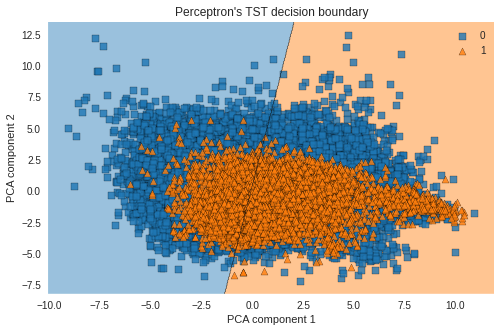

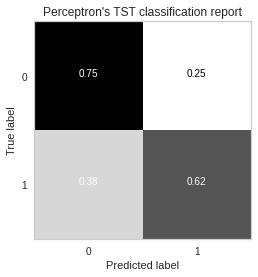

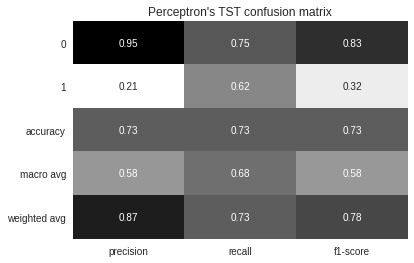

roc 0.6825490285057366


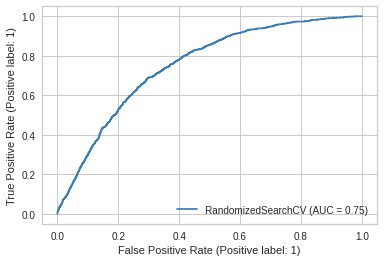

In [44]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst, best_features, best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False,
                                                                scaler_flag=True, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

In [45]:
# estimating model's predict_proba via CalibratedClassifierCV, since the model doesn't implement one
svm = tuned_model_tst
clf = CalibratedClassifierCV(svm) 
X_tr_curr = X_train
X_ts_curr = X_test
discretizer = MinMaxScaler()
X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
X_ts_curr = discretizer.transform(X_ts_curr.values)
clf.fit(X_tr_curr, y_train.values.ravel())
y_proba = clf.predict_proba(X_ts_curr)
y_prob_tst = y_proba

<Figure size 576x360 with 0 Axes>

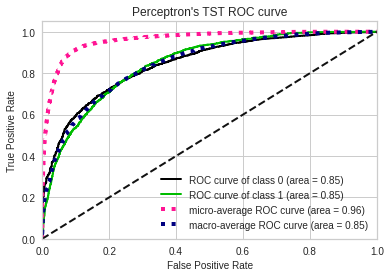

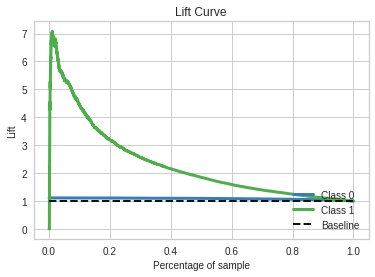

In [46]:
plot_roc_curve(y_ts, y_proba)
plot_lift_curve(y_ts, y_proba)

<font color="red"> <h1> Dimensionality reduction</h1></font>

Dimensionality reduction refers to techniques that reduce the number of input variables in a
dataset. More input features often make a predictive modeling task more challenging to model,
more generally referred to as the **curse of dimensionality**.

Dimensionality reduction methods include:
- feature selection: use scoring or statistical methods to select which features to keep and which features to delete:
    - **Wrapper methods**, wrap a machine learning model, fitting and evaluating the model with different subsets 
      input features and selecting the subset the results in the best model performance. (i.e. RFE);
    - **Filter methods** use scoring methods between the feature and the target variable, to select a
      subset of input features that are most predictive (i.e. Pearson’s correlation or Chi-Squared test).
- linear algebra methods:
    - **Matrix Factorization**: feature matrix (i.e. covariance matrix) can  be ranked and a subset of those parts can       be selected that best captures the salient structure of thematrix that can be used to represent the dataset.       (i.e. PCA);
- projection methods / manifold learning and are used to create a low-dimensional projection of high-dimensional data, whilst best preserving the salient structure or relationships in the data (i.e. SOM);
- autoencoders: A nueral network model is used that seeks to compress the data flow to a bottleneck layer with far fewer dimensions than the original input data. The part of the model prior to and including the bottleneck is referred to as the encoder, and the part of the model that reads the bottleneck output and reconstructs the input is called the decoder.

<u>Typically, linear algebra and manifold learning methods
assume that all input features have the same scale or distribution. This suggests that it is
good practice to either normalize or standardize data prior to using these methods.</u>

<b><font color="green"> 
For our feature selection process we decided to first use the Pearson Correlation Method to remove highly correlated features (see Features_Data_Understandind.ipynb);
Since data dimensionality was still high, we evaluate three different roads:
- Univariate Method, using SelectKBest with the ANOVA F-test, since our continous variables are almost alway normal distributed, while our classification target is categorical;
- Feature Importance Method, using RFE with features ranked according to feature_importances_ or coef_ derived from a DecisionTreeClassifier() and a LogisticRegression(), respectively;
- Variance Threshold, removing features whose variance doesn’t meet a threshold equalt to 0.01
</font></b>

<h2>ANOVA feature selection (filter method)</h2>

<u> Importantly, ANOVA is used when one variable is numeric and one is categorical, such as
numerical input variables and a classification target variable in a classification task.</u>

ANOVA is an acronym for analysis of variance and is a parametric statistical hypothesis test for
determining whether the means from two or more samples of data (often three or more) come
from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that
calculate the ratio between variances values, such as the variance from two different samples or
the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method
is a type of F-statistic referred to here as an **ANOVA F-test**.


The scikit-learn machine library provides an implementation of the ANOVA F-test in the
f **classif()** function. This function can be used in a feature selection strategy, such as selecting
the top k most relevant features (largest values) via the **SelectKBest** class.


We cawilln systematically test a range
of different numbers of selected features and discover which results in the best performing
model. This is called a grid search, where the k argument to the SelectKBest class can be
tuned. It is good practice to evaluate model configurations on classification tasks using repeated
stratified k-fold cross-validation. We will use **3-fold cross-validation** via the
**StratifiedKFold** class.

**Since both class labels are equally important and we assign equl cost to FN and FP, we will use as GridSearch's scoring metric the f1_weighted measure** (we want a trade-off among precision and recall).

N.B. 
- f1_macro => unweighted class label
- f1_weighted => weighted class label

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70699831 0.56110078        nan        nan 0.58975345 0.68290757
 0.83458444 0.61664352 0.61666796        nan]
  warnings.warn(


Best Mean F1_weighted: 0.835 
Best Config: {'preprocessor__numeric__scaler': MaxAbsScaler(), 'model__tol': 1e-05, 'model__penalty': 'l1', 'model__eta0': 0.01, 'model__alpha': 1.0, 'anova__k': 3} 


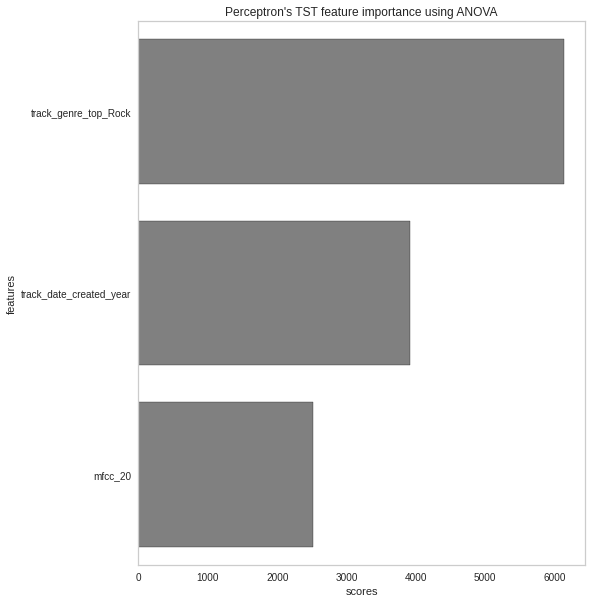

/home/alexandra/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


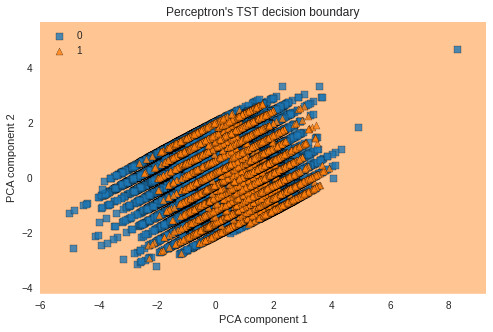

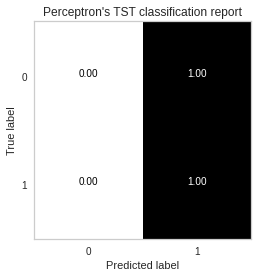

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


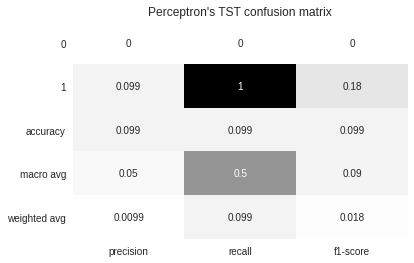

roc 0.5


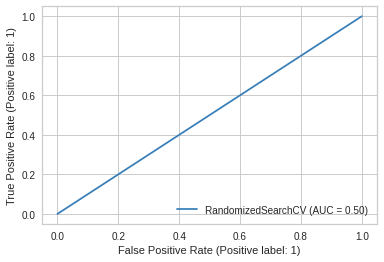

In [47]:
anova_params_tst, anova_tuned_model_tst, anova_y_pred_tst, anova_y_prob_tst, \
                anova_best_features, anova_best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="anova", 
                                                                feature_flag=False)

<h2>RFE (Recursive Feature Elimination) (wrapper method)</h2>

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

RFE **requires a nested algorithm that is used to provide the feature importance scores**, such
as a decision tree (**feature_importances_ attribute**) or a linear model(**coef_ attribute**).

Feature importance refers to techniques that assign a score to input features based on how
useful they are at predicting a target variable:
- statistical correlation scores;
- coefficients calculated as part of linear models or decision trees;
- permutation importance scores.

<u> RFECV automatic select best k number of features </h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.726 
Best Config: {'rfe__n_features_to_select': 49, 'rfe__estimator': DecisionTreeClassifier(), 'preprocessor__numeric__scaler': StandardScaler(), 'model__tol': 0.1, 'model__penalty': 'elasticnet', 'model__eta0': 0.1, 'model__alpha': 0.001} 


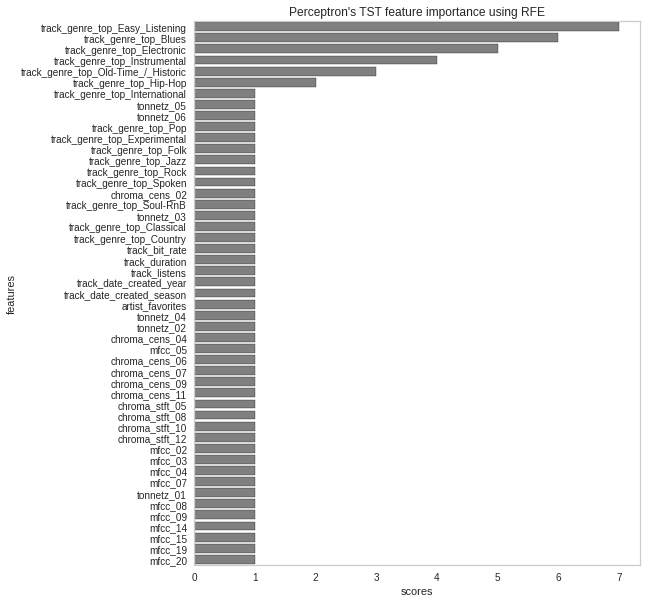

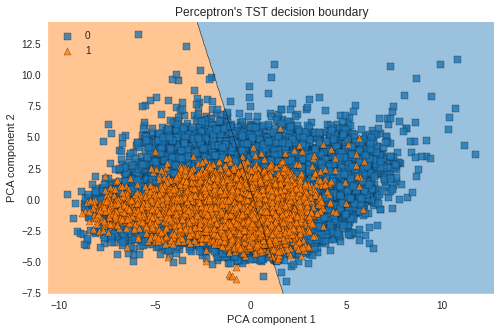

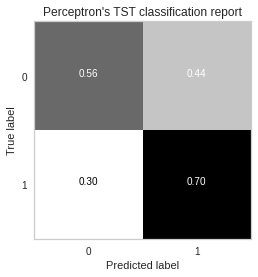

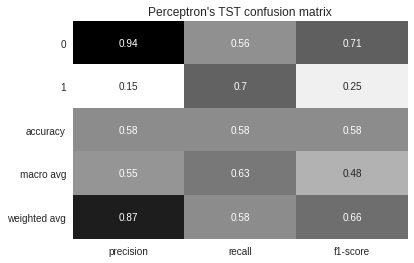

roc 0.6310834675803025


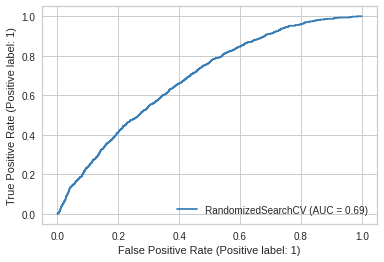

In [48]:
rfe_params_tst, rfe_tuned_model_tst, rfe_y_pred_tst, rfe_y_prob_tst, \
                rfe_best_features, rfe_best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="rfe", 
                                                                feature_flag=False)

<h2>Variance Threshold</h2>

Since we have many features, we remove all features whose variance doesn’t meet some threshold. By default, VarianceThreshold removes all zero-variance features, i.e. features that have the same value in all samples.

<u>This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.</u>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.663 
Best Config: {'preprocessor__numeric__scaler': StandardScaler(), 'model__tol': 1e-05, 'model__penalty': 'elasticnet', 'model__eta0': 0.0001, 'model__alpha': 0.01} 


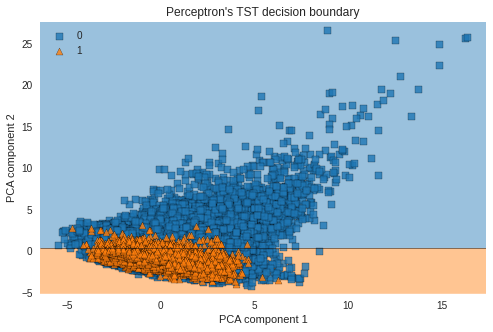

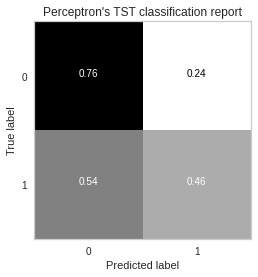

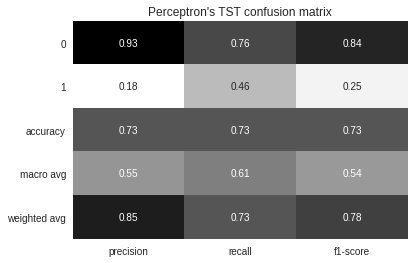

roc 0.6114590187491964


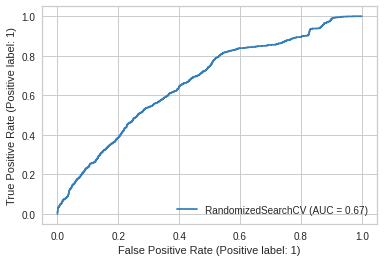

In [49]:
vt_params_tst, vt_tuned_model_tst, vt_y_pred_tst, vt_y_prob_tst, \
                vt_best_features, vt_best_features_scores = \
                                                    grid_search(X_tr=X_tr_vt, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts_vt, 
                                                                y_ts=y_ts,
                                                                 numeric_features=numeric_columns_vt, 
                                                                categorical_features=categoric_columns_vt, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

<h2> Test curves </h2>

In [50]:
def draw_multiple_roc_curves(global_info, model_names, v_or_t_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fprs = []
    tprs = []
    labels = []
    for model_name in global_info.keys():
        fpr = global_info[str(model_name)]["fpr"]
        tpr = global_info[str(model_name)]["tpr"]
        roc_auc = global_info[str(model_name)]["roc"] 
        label = '%s model=%0.4f' % (model_name, roc_auc)
        
        fprs.append(fpr)
        tprs.append(tpr)
        labels.append(label)
    
        # plt.plot(fpr, tpr, label='%s model=%0.4f' % (model_name, roc_auc))
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--', color="k", label='No-skilled model=0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="Weighted AUC", frameon=True)
    plt.title("%s' %s ROC-curve" % (model_names, v_or_t_flag))
    plt.show()

In [51]:
from sklearn.metrics import auc, roc_curve, roc_auc_score 

def get_roc_curve_and_roc_auc_score(y_tst, y_prd, curr_model_name, global_info):
    fpr, tpr, thresholds = roc_curve(y_tst, y_prd)
    roc = roc_auc_score(y_tst, y_prd, average="weighted")
    
    global_info[str(curr_model_name)]["fpr"] = fpr
    global_info[str(curr_model_name)]["tpr"] = tpr
    global_info[str(curr_model_name)]["roc"] = roc
    
    return global_info

In [53]:
global_info = {}
global_info["Plain"] = {}
global_info["ANOVA"] = {}
global_info["RFE"] = {}
global_info["VarianceThreshold"] = {}

global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), y_prob_tst[:, 1], "Plain", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), anova_y_prob_tst, "ANOVA", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), rfe_y_prob_tst, "RFE", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), vt_y_prob_tst, "VarianceThreshold", global_info)

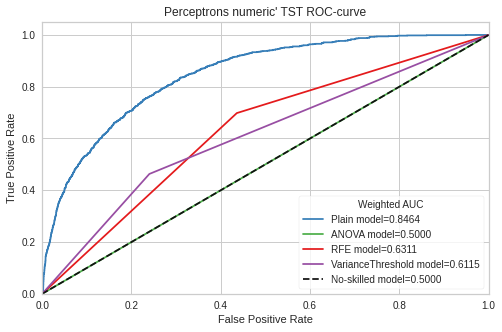

In [54]:
draw_multiple_roc_curves(global_info, model_name + "s numeric" , v_or_t_flag)

<h2>Learning curves </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

<h6>Saving best model on file</h6>

In [98]:
import pickle

model_info = {'model_name': 'Plain',
              'params': params_tst,
              'tuned_model': tuned_model_tst,
              'y_pred': y_pred_tst,
              'y_prob': y_prob_tst,
              'best_features': best_features,
              'best_features_scores': best_features_scores
             }

with open('pickle/' + model_name + '_balanced.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)